In [1]:
import numpy
import pandas
import torch
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Load training data into tensor objects + plot the data
def loadData(tsv_fn, plot = False):
    
    data = pandas.read_csv(tsv_fn, sep = "\t")
    
    if plot:

        data_melt = pandas.melt(data, id_vars="diagnosis")
        sns.boxplot(x="variable", y="value", hue="diagnosis", data=data_melt, palette="Set2")
        
    features = data.iloc[:,:5].values
    labels = data.iloc[:,5].values
    
    return torch.tensor(features, dtype = torch.float), torch.tensor(labels, dtype = torch.float).view(-1,1)

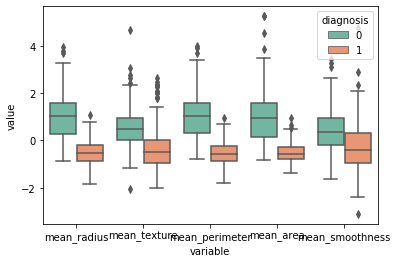

In [3]:
train_features, train_labels = loadData("Breast_cancer_data_scaled_train.tsv", plot = True)

In [4]:
train_features

tensor([[-0.6746, -0.4021, -0.6617, -0.6592,  0.7778],
        [-0.8704, -1.0067, -0.8428, -0.7985,  0.4934],
        [-0.3227, -1.1764, -0.3247, -0.3995, -0.1237],
        ...,
        [-0.8647, -1.0648, -0.8955, -0.8019,  0.3015],
        [-0.2121,  2.6576, -0.2317, -0.2776, -0.2780],
        [-0.8136,  0.1559, -0.7510, -0.7411, -1.1490]])

In [5]:
train_labels

tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
      

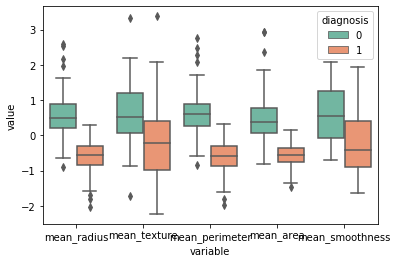

In [6]:
test_features, test_labels = loadData("Breast_cancer_data_scaled_test.tsv", plot = True)

We'll try to model the log likelihood of the data, which can be written as:

$\text{log L} = Y_i\cdot \text{ln}(P_i)+(1-Y_i)\cdot \text{ln}(1-P_i)$

where Y are the labels and P the probability from the logistic regression. We will try to maximize the log likelihood for our data. 

The question is, in which direction does the estimated parameters need to change so that the likelihood is maximized?. Pytorch finds this gradient and optimizes the likelihood function. It does so by:
* Initializing the parameters (beta, for example).
* For a number of epochs:
    * Calculate the gradients for the parameters from the log likelihood function.
    * Update the parameters based on the gradient, by using a certain step size. The most simple optimization scheme is the gradient descent, where $param = stepsize*gradient+param$.
    * Reset the gradients.


### Naive implementation of Pytorch

We can try to optimize the likelihood data by using some pytorch magic. We will need to define a set of functions first. `calcPredAccuracy` calculates the accuracy between the empirical labels (`labels`) and the predicted labels (obtained from the predicted probabilities `prob`):

In [7]:
def calcPredAccurary(prob, labels, threshold = 0.5):
    
    predicted_labels = prob > threshold
    correct_labels = predicted_labels.int() == labels.int()
    
    return correct_labels.sum().float() / prob.shape[0]

We also need to define `calcLogisticLogLikelihood`, which computes the log likelihood of a logistic regression (the formula above). We can do so by imputing the probabilities predicted from out model (`prob`) and the real labels of the training data (`labels`).

In [8]:
def calcLogisticLogLikelihood(prob, labels):
    return (labels*(prob.log()) + (1-labels)*((1-prob).log())).sum()

We can initialize the intercepts as ones using `addInterceptCol`. By setting them to 1, it means that when we do matrix multiplication the correspondent beta value is added to the value. This means that the first beta is the intercept. 

In [9]:
def addInterceptCol(tensor):
    column_of_ones = torch.ones((tensor.shape[0],1), dtype = tensor.dtype) 
    lst = [column_of_ones, tensor]    
    return torch.cat(lst, 1)

Finally, we are able to write the workflow. This is much easier when using Pytorch methods on the tensors. For example, `<loss>.backward()` computes `dloss/dx` for every parameter `x` which has `requires_grad=True`. Because we are trying to optimize the betas (and the intercept) we will create a tensor of betas that require the computing of the gradient. 

In [10]:
#####
# LOGISTIC REGRESSION - naive approach
#####

# Define the step
learning_rate = 1e-3

# Add the intercept to the training features
train_features_intercept = addInterceptCol(train_features)
# Initialize betas and the intercept randomly (5+1)
betas = torch.rand((6,1), requires_grad = True, dtype = torch.float)

# Specify number of iterations
num_iterations = 1000

for i in range(num_iterations):
    
    # calculate predictions of a linear regression model
    pred = torch.mm(train_features_intercept, betas)      
    # calculate probabilities by tranforming predictions with the sigmoid function
    prob = torch.sigmoid(pred)     

    # compute the log likelihood (loss function)
    log_ll = calcLogisticLogLikelihood(prob, train_labels)
    # apply the backward method to the loss
    log_ll.backward()
    
    # because we are applying our own learning rate and optimization, we
    # will set torch to no gradient so we can add the gradient manually
    with torch.no_grad():
        # update betas
        betas += learning_rate*betas.grad
    
    # set gradients to zero
    betas.grad.data.zero_()
    
# print the final accuracy
print(calcPredAccurary(prob, train_labels).item())
    

0.9340659379959106


### Introducing the Pytorch optimizers

The naive implementation of Pytorch can be simplified by using its built-in optimizers. In this case, we will use an Adam optimizer. Note that Adam minimizes the loss function, so we need to multiply the log likelihood by (-1) to make it work.

In [17]:
#####
# LOGISTIC REGRESSION - with built-in optimizers
#####

# Define the step
learning_rate = 1e-3

# Add the intercept to the training features
train_features_intercept = addInterceptCol(train_features)
# Initialize betas and the intercept randomly (5+1)
betas = torch.rand((6,1), requires_grad = True, dtype = torch.float)

# Specify number of iterations
num_iterations = 1000

# DEFINE THE OPTIMIZER - Adam in this case
optim = torch.optim.Adam([betas], learning_rate)

for i in range(num_iterations):
    
    # calculate predictions of a linear regression model
    pred = torch.mm(train_features_intercept, betas)      
    # calculate probabilities by tranforming predictions with the sigmoid function
    prob = torch.sigmoid(pred)     

    # NEGATIVE - Adam minimizes
    log_ll = -calcLogisticLogLikelihood(prob, train_labels)
    # apply the backward method to the loss
    log_ll.backward()
    
    # automatically optimize the betas
    optim.step() 
    
    # to set gradients to zero
    optim.zero_grad()
    
# print the accuracy
print(calcPredAccurary(prob, train_labels).item())

0.8373626470565796


In [12]:
# def addInterceptCol(tensor):
# def calcLogisticLogLikelihood(prob, labels):
# def calcPredictionAccuracy(prob, labels, threshold = 0.5):
# def estimateLogisticRegressionModel(...):
#   1. Initialize parameters
#   2. Until convergence:
#      1. Calculate log-likelihood on training data
#      2. Backpropagate gradients
#      3. Update parameters
#      4. Zero gradients!!!